In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [21]:
dataset = pd.read_csv("Data/Big Mart Train Data.csv")
test = pd.read_csv("Data/Big Mart Test.csv")

#Showing a sample of the dataset
print(dataset.head())

# Moving categorical variables to the same section of the dataset so they can be operated on separately from numerical data.
categorical = dataset.pop("Item_Identifier")
dataset.insert(10,"Item_Identifier", categorical)
categorical = dataset.pop("Item_Fat_Content")
dataset.insert(10,"Item_Fat_Content", categorical)
categorical = dataset.pop("Item_Type")
dataset.insert(10,"Item_Type", categorical)
categorical = dataset.pop("Outlet_Identifier")
dataset.insert(10,"Outlet_Identifier", categorical)

# Repeat for the test dataset
categorical = test.pop("Item_Identifier")
test.insert(10,"Item_Identifier", categorical)
categorical = test.pop("Item_Fat_Content")
test.insert(10,"Item_Fat_Content", categorical)
categorical = test.pop("Item_Type")
test.insert(10,"Item_Type", categorical)
categorical = test.pop("Outlet_Identifier")
test.insert(10,"Outlet_Identifier", categorical)

# Splitting numerical data from categorical data for both the test and training set.
X = dataset.iloc[:,:-1]
X_num = X.iloc[:,:4]
X_cat = X.iloc[:,4:]

X_test = test.iloc[:,:]
X_num_test = X_test.iloc[:,:4]
X_cat_test = X_test.iloc[:,4:]

Y = dataset.iloc[:,-1]

  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier

# Understanding our missing data using Seaborn and MatplotLib

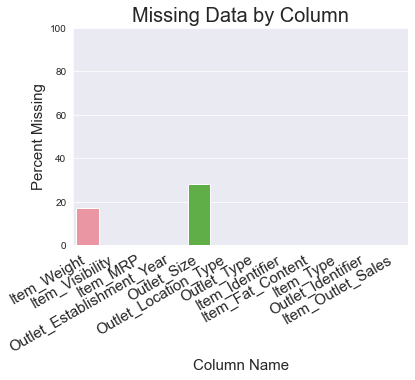

In [22]:
missing_percentages = dataset.isnull().sum()*100/len(dataset)

sb.barplot(x=missing_percentages.keys(), y=missing_percentages)
plt.title('Missing Data by Column',size=20)
plt.xlabel('Column Name',size=15)
plt.ylabel('Percent Missing',size=15)
plt.ylim(0,100)
plt.xticks(rotation=30,size=15, ha="right")

plt.show()

print()

This shows that we're missing data for a numerical varaible (Item_weight) and a categorical variable (Outlet_size). For those two variables ~18% and ~30% of the rows respectively are missing data. This is too large of a percentage to be comfortable just removing those rows from the dataset.

# Imputing missing data

In [23]:
from sklearn.impute import SimpleImputer
NumericalImputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_num = pd.DataFrame(NumericalImputer.fit_transform(X_num), columns=X_num.columns)
X_num_test = pd.DataFrame(NumericalImputer.transform(X_num_test), columns=X_num_test.columns)

CategoricalImputer = SimpleImputer(missing_values=np.nan, strategy="constant",fill_value="Missing Value")

X_cat = pd.DataFrame(CategoricalImputer.fit_transform(X_cat), columns=X_cat.columns)
X_cat_test = pd.DataFrame(CategoricalImputer.transform(X_cat_test), columns=X_cat_test.columns)

Here we imputed our missing numerical data using the mean of its column. Our categorical missing data is then imputed by creating a new category: "Missing Value" for each of the columns.

# One Hot and Ordinal Encoding Categorical Data

In [24]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
item_ident = X_cat.iloc[:,3]
item_ident_test = X_cat_test.iloc[:,3]
X_cat.iloc[:,3] = encoder.fit_transform(np.asarray(item_ident).reshape(len(item_ident),1))
X_cat_test.iloc[:,3] = encoder.fit_transform(np.asarray(item_ident_test).reshape(len(item_ident_test),1))

encoder2 = OrdinalEncoder()
outlet_ident = X_cat.iloc[:,-1]
outlet_ident_test = X_cat_test.iloc[:,-1]
X_cat.iloc[:,-1] = encoder2.fit_transform(np.asarray(outlet_ident).reshape(len(outlet_ident),1))
X_cat_test.iloc[:,-1] = encoder2.fit_transform(np.asarray(outlet_ident_test).reshape(len(outlet_ident_test),1))

# One hot encoding using the Pandas get_dummies function.
X_cat = pd.get_dummies(X_cat)
X_cat_test = pd.get_dummies(X_cat_test)

# These print statements can be used to make sure that the shapes of each portion of the dataset match
#print(X_cat.shape)
#print(X_cat_test.shape)
#print(X_num.shape)

# Recombining categorical and numerical data into X and X_test.
X = pd.concat([X_cat,X_num], axis=1)
X_test = pd.concat([X_cat_test,X_num_test], axis=1)
#print(X_test.shape)
#print(X.shape)

Here we ordinally encoded the item_identifier and outlet_identifier categories because they contain too many values to one hot encode nicely. We then one hot encode our categorical data using the get_dummies function. Finally, we recombined the categorical and numerical data into a training and test dataset now that their operations are finished.

# Creating a Validation Split and Parameter Set for Tuning

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state = 0)

parameters = {
    "n_estimators": [i for i in range(20,1000,20) ],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [None, 10, 20, 30, 40, 50],
}

# Creating the Regressor and Hyperparameter Tuning

In [ ]:
#from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

regressor = RandomForestRegressor(random_state=0)
search_regressor = RandomizedSearchCV(estimator=regressor,param_distributions=parameters,n_iter=500,cv=5, random_state=0)

search_regressor.fit(X_train,Y_train)
print(search_regressor.best_params)

# Running the Regressor on the Dataset

In [25]:

#regressor = DecisionTreeRegressor(random_state=0, max_depth=25)
regressor.fit(X,Y)

y_pred = regressor.predict(X_test)

# Outputting the Results to CSV

In [26]:
item = np.asarray(X_test["Item_Identifier"]).reshape(len(X_test["Item_Identifier"]),1)
outlet = np.asarray(X_test["Outlet_Identifier"]).reshape(len(X_test["Outlet_Identifier"]),1)

final_out = pd.concat([pd.DataFrame(encoder.inverse_transform(item),columns=["Item_Identifier"]), pd.DataFrame(encoder2.inverse_transform(outlet),columns=["Outlet_Identifier"]), pd.DataFrame(y_pred, columns=["Item_Outlet_Sales"])], axis=1)
final_out = final_out.to_csv("solution.csv",index=False)

print(final_out)

None
